### TESTES REPEATED-MEASURES ANOVA

Conjunto de 3 testes: One-way repeated measures ANOVA, Two-way repeated measures ANOVA e Three-way repeated measures ANOVA. Compara dois ou mais grupos ou amostras emparelhadas.

A ANOVA de medidas repetidas é um teste estatístico para a análise de dados longitudinais pareados. Isto significa que o mesmo conjunto de participantes foi acompanhado e avaliado no decorrer do tempo. Os pressupostos deste teste são:

- Os dados são aleatórios e representativos da população
- A variável dependente é contínua
- Os resíduos do modelo são normalmente distribuídos
- Há esfericidade dos grupos

In [2]:
# DESATIVA NOTAÇÃO CIENTÍFICA
options(scipen = 999)

In [3]:
# DESATIVAR MENSAGENS DE WARNINGS (warn = -1) E ATIVAR (warn = 0)
options(warn = -1)

In [4]:
# CARREGAR BIBLIOTECAS
suppressPackageStartupMessages({
library(dplyr)
library(multcomp)
library(RcmdrMisc)
library(BSDA)
library(ggpubr)
library(tidyverse)
library(rstatix)
library(datarium)
})

#### CARREGAR DATASET

O dataset contém a pontuação de autoestima de 10 indivíduos em três pontos de tempo durante uma dieta específica para determinar se sua autoestima melhorou.

A ANOVA de medidas repetidas unilaterais pode ser usada para determinar se as médias dos escores de autoestima são significativamente diferentes entre os três momentos.

####  ONE-WAY REPEATED MEASURES ANOVA 

* Premissa 1: há outiliers extremos? Se houver **outiliers extremos** precisam ser deletados. 
Isso ocorre devido a erros de entrada de dados, erros de medição ou valores incomuns. O outlier pode ser incluído na análise se for percebido que o resultado não foi substancialmente alterado. Isso pode ser feito comparando o resultado ANOVA com e sem outilier. Também é possível manter os outiliers e realizar um teste ANPVA robusto usando o pacote WRS2.

* Premissa 2: normalidade dos dados.

In [7]:
data("selfesteem", package = "datarium")
head(selfesteem, 3)

id,t1,t2,t3
1,4.005027,5.182286,7.107831
2,2.558124,6.912915,6.308434
3,3.244241,4.443434,9.778410


In [8]:
# CONVERTER COLUNA TEMPO EM LINHA
selfesteem <- selfesteem %>%
  gather(key = "time", value = "score", t1, t2, t3) %>%
  convert_as_factor(id, time)
head(selfesteem, 3)

glimpse(selfesteem)

id,time,score
1,t1,4.005027
2,t1,2.558124
3,t1,3.244241


Rows: 30
Columns: 3
$ id    <fct> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1,~
$ time  <fct> t1, t1, t1, t1, t1, t1, t1, t1, t1, t1, t2, t2, t2, t2, t2, t2, ~
$ score <dbl> 4.005027, 2.558124, 3.244241, 3.419538, 2.871243, 2.045868, 3.52~


In [9]:
selfesteem %>%
  group_by(time) %>%
  get_summary_stats(score, type = "mean_sd")

time,variable,n,mean,sd
t1,score,10,3.140,0.552
t2,score,10,4.934,0.863
t3,score,10,7.636,1.143


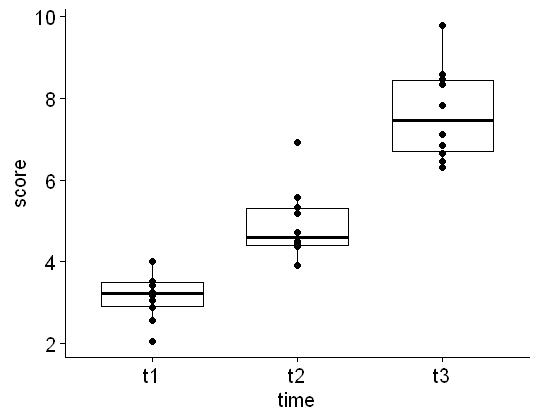

In [10]:
# GRÁFICO BOX PLOT
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
ggboxplot(selfesteem, x = "time", y = "score", add = "point")

#### TESTE DE OUTILIERS

In [11]:
selfesteem %>%
  group_by(time) %>%
  identify_outliers(score)

time,id,score,is.outlier,is.extreme
t1,6,2.045868,TRUE,FALSE
t2,2,6.912915,TRUE,FALSE


Não existem outiliers extremos.

#### TESTE DE NORMALIDADE

Hipóteses Teste de Shapiro-Wilk:

- Ho: os dados são normalmente distribuídos
- Ha: os dados não são normalmente distribuídos

Critérios do Teste de Shapiro-Wilk:

- Se p-value for menor que nível de significância, rejeita-se Ho.

In [12]:
selfesteem %>%
  group_by(time) %>%
  shapiro_test(score)

time,variable,statistic,p
t1,score,0.9666901,0.8585757
t2,score,0.8758846,0.1169956
t3,score,0.9227150,0.3801563


Apresentou distribuição normal em cada tempo.

Observe que, se o tamanho da sua amostra for maior que 50, o gráfico QQ normal é preferido porque em tamanhos de amostra maiores, o teste de Shapiro-Wilk se torna muito sensível até mesmo a um pequeno desvio da normalidade.

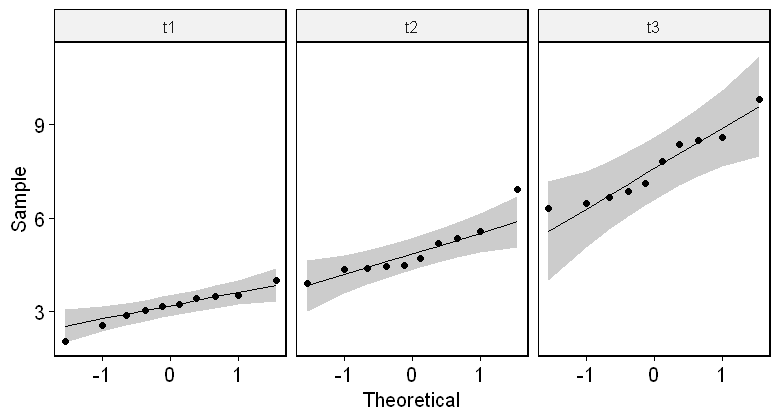

In [13]:
# O GRÁFICO QQ DESENHA A CORRELAÇÃO ENTRE UM DADO E A DISTRIBUIÇÃO NORMAL QQ.
# GRÁFICOS QQ PARA CADA PONTO DE TEMPO:
options(repr.plot.width = 6.5, repr.plot.height = 3.5)
ggqqplot(selfesteem, "score", facet.by = "time")

Conforme gráfico acima, como todos os pontos caem aproximadamente ao longo da linha de referência, pode-se assumir a normalidade.

#### SUPOSIÇÃO DE ESFERICIDADE

A suposição de esfericidade será verificada automaticamente durante o cálculo do teste ANOVA usando a função anova_test() do pacote rstatix. O teste de Mauchly é usado internamente para avaliar a suposição de esfericidade. Usando a função get_anova_table() do rstatix para extrair a tabela ANOVA, a correção de esfericidade Greenhouse-Geisser é aplicada automaticamente aos fatores que violam a suposição de esfericidade.

#### TESTE ONE-WAY REPEATED MEASURES ANOVA

In [14]:
analise_variancia2 <- anova_test(data = selfesteem, dv = score, wid = id, within = time)
analise_variancia2
get_anova_table(analise_variancia2)

ANOVA Table (type III tests)

$ANOVA
  Effect DFn DFd      F            p p<.05   ges
1   time   2  18 55.469 0.0000000201     * 0.829

$`Mauchly's Test for Sphericity`
  Effect     W     p p<.05
1   time 0.551 0.092      

$`Sphericity Corrections`
  Effect  GGe      DF[GG]      p[GG] p[GG]<.05   HFe      DF[HF]       p[HF]
1   time 0.69 1.38, 12.42 0.00000216         * 0.774 1.55, 13.94 0.000000603
  p[HF]<.05
1         *

Effect,DFn,DFd,F,p,p<.05,ges
time,2,18,55.469,0.0000000201,*,0.829


O score de autoestima foi **estatisticamente significativo para diferença** nos diferentes momentos durante a dieta, F (2, 18) = 55,469, p <0,0001, eta2 [g] = 0,829. F Indica que estamos comparando a uma distribuição F(teste F); (2, 18) indica os graus de liberdade no numerador (DFn) e no denominador (DFd), respectivamente; 55,469 indica o valor obtido da estatística F, p especifica o p-value, "ges" é o tamanho do efeito generalizado (quantidade de variabilidade devido ao fator within-subjects).



#### TESTES POST-HOC

Pode-se realizar vários testes t-student pareados por pares entre os níveis do fator within-subjects (time). Os valores P são ajustados usando o método de correção do teste múltiplo de Bonferroni.

In [15]:
# COMPARAÇÕES POR PARES
pwc <- selfesteem %>%
  pairwise_t_test(
    score ~ time, paired = TRUE,
    p.adjust.method = "bonferroni"
  )
pwc

.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif
score,t1,t2,10,10,-4.967618,9,0.000772000,0.002000,**
score,t1,t3,10,10,-13.228148,9,0.000000334,0.000001,****
score,t2,t3,10,10,-4.867816,9,0.000886000,0.003000,**


Todas as diferenças entre pares são estatisticamente significativas.

Resultados:

O escore de autoestima foi diferente estatisticamente significativo nos diferentes tempos, F (2, 18) = 55,5, p <0,0001, (ges) eta generalizado ao quadrado = 0,82. As análises post-hoc com um ajuste de Bonferroni revelaram que todas as diferenças aos pares, entre os pontos de tempo, foram diferentes estatisticamente significativas (p <= 0,05).

In [17]:
# VISUALIZAÇÃO: BOX-PLOTS COM p-VALUES
options(repr.plot.width = 5, repr.plot.height = 4)
pwc <- pwc %>% add_xy_position(x = "time")
bxp + 
stat_pvalue_manual(pwc) +
labs(
    subtitle = get_test_label(analise_variancia2, detailed = TRUE),
    caption = get_pwc_label(pwc)
)

ERROR: Error in bxp + stat_pvalue_manual(pwc) + labs(subtitle = get_test_label(analise_variancia2, : argumento não-numérico para operador binário


-------------------------------------------------------------------------------------------------------------------------------

#### TWO-WAY REPEATED MEASURES ANOVA 

In [18]:
set.seed(123)
data("selfesteem2", package = "datarium")
selfesteem2 %>% 
sample_n_by(treatment, size = 1)

id,treatment,t1,t2,t3
3,ctr,93,92,89
3,Diet,91,91,92


In [19]:
# CONVERTER COLUNA t1, t2 e t3 EM LINHA
selfesteem2 <- selfesteem2 %>%
  gather(key = "time", value = "score", t1, t2, t3) %>%
  convert_as_factor(id, time)
glimpse(selfesteem2)

Rows: 72
Columns: 4
$ id        <fct> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, ~
$ treatment <fct> ctr, ctr, ctr, ctr, ctr, ctr, ctr, ctr, ctr, ctr, ctr, ctr, ~
$ time      <fct> t1, t1, t1, t1, t1, t1, t1, t1, t1, t1, t1, t1, t1, t1, t1, ~
$ score     <dbl> 83, 97, 93, 92, 77, 72, 92, 92, 95, 92, 92, 79, 84, 100, 91,~


In [20]:
# INSPECIONAR ALGUMAS ALEATÓRIAS DOS DADOS POR GRUPOS
set.seed(123)
selfesteem2 %>% 
sample_n_by(treatment, time, size = 1)

id,treatment,time,score
3,ctr,t1,93
3,ctr,t2,92
10,ctr,t3,81
2,Diet,t1,100
6,Diet,t2,75
11,Diet,t3,91


Neste exemplo, o efeito do "tempo" na pontuação da autoestima é nossa variável focal, essa é nossa principal preocupação. Porém, pensa-se que o "tempo" de efeito será diferente se o tratamento for realizado ou não. Nesse cenário, a variável "tratamento" é considerada variável moderadora.

In [ ]:
# AGRUPAR OS DADOS POR TRATAMENTO E TEMPO E CALCULANDO ALGUMAS ESTATÍSTICAS DA VARIÁVEL DE PONTUAÇÃO: MÉDIA E DESVIO PADRÃO
selfesteem2 %>%
  group_by(treatment, time) %>%
  get_summary_stats(score, type = "mean_sd")

In [ ]:
# BOX PLOT DO SCORE POR GRUPOS DE TRATAMENTO
bxp <- ggboxplot(
  selfesteem2, x = "time", y = "score",
  color = "treatment", palette = "jco"
)
bxp

#### TESTE DE OUTILIERS

In [ ]:
selfesteem2 %>%
  group_by(treatment, time) %>%
  identify_outliers(score)

Não há outliers extremos.

#### TESTE DE NORMALIDADE

Hipóteses Teste de Shapiro-Wilk:

- Ho: os dados são normalmente distribuídos
- Ha: os dados não são normalmente distribuídos

Critérios do Teste de Shapiro-Wilk:

- Se p-value for menor que nível de significância, rejeita-se Ho.

In [ ]:
selfesteem2 %>%
  group_by(treatment, time) %>%
  shapiro_test(score)

O score de autoestima apresentou distribuição normal em cada momento (p> 0.05), exceto para o tratamento ctr em t1, avaliado pelo teste de Shapiro-Wilk.

In [ ]:
# O GRÁFICO QQ DESENHA A CORRELAÇÃO ENTRE UM DADO E A DISTRIBUIÇÃO NORMAL QQ.
# GRÁFICOS QQ PARA CADA GRUPO:
options(repr.plot.width = 6.5, repr.plot.height = 3.5)
ggqqplot(selfesteem, "score", facet.by = "time")

No gráfico, como todos os pontos caem aproximadamente ao longo da linha de referência, podemos assumir a normalidade.

#### TESTE TWO-WAY REPEATED MEASURES ANOVA

In [ ]:
analise_variancia3 <- anova_test(
  data = selfesteem2, dv = score, wid = id,
  within = c(treatment, time)
)
analise_variancia3

get_anova_table(analise_variancia3)

Existe uma interação bidirecional estatisticamente significativa entre o tratamento e o tempo, F (2, 22) = 30.4, p < 0.0001.

#### TESTES POST-HOC

Uma interação bidirecional significativa indica que o impacto que um fator (por exemplo, tratamento) tem sobre a variável de resultado (por exemplo, pontuação de autoestima) depende do n?vel do outro fator (por exemplo, tempo) (e vice-versa). Portanto, você pode decompor uma interação bidirecional significativa em:
  
* Efeito principal simples: execute o modelo unilateral da primeira variável (fator A) em cada nível da segunda variável (fator B),

* Comparações de pares simples: se o efeito principal simples for significativo, execute várias comparações de pares para determinar quais grupos são diferentes.

Para uma interação bidirecional não significativa, você precisa determinar se há algum efeito principal estatisticamente significativo no resultado da ANOVA.

**Procedimento para uma interação bidirecional significativa**

* Efeito do tratamento. Em nosso exemplo, analisaremos o efeito do tratamento na pontuação da autoestima em cada momento. 
Observe que a variável do fator de tratamento possui apenas dois níveis ("ctr" e "Diet"); assim, o teste ANOVA e o teste t pareado fornecerão os mesmos p-values.

* Efeito do tempo. Observe que também é possível realizar a mesma análise para a variável de tempo em cada nível de tratamento. Você não precisa necessariamente fazer essa análise.

In [ ]:
# EFEITO DO TRATAMENTO EM CADA PONTO NO TEMPO
one.way <- selfesteem2 %>%
  group_by(time) %>%
  anova_test(dv = score, wid = id, within = treatment) %>%
  get_anova_table() %>%
  adjust_pvalue(method = "bonferroni")
one.way

In [ ]:
# COMPARAÇÕES DE PARES ENTRE GRUPOS DE TRATAMENTO
pwc <- selfesteem2 %>%
  group_by(time) %>%
  pairwise_t_test(
    score ~ treatment, paired = TRUE,
    p.adjust.method = "bonferroni"
  )
pwc

Considerando o p-value ajustado de Bonferroni (p.adj), verifica-se que o simples efeito principal do tratamento não foi significativo no momento t1 (p = 1). Torna-se significativo em t2 (p = 0.036) e t3 (p = 0.00051).

As comparaçães pareadas mostram que a pontuação média de autoestima foi significativamente diferente entre ctr e o grupo Dieta em t2 (p = 0.12) e t3 (p = 0.00017), mas não em t1 (p = 0.55).

In [ ]:
# EFEITO DO TEMPO EM CADA NÍVEL DE TRATAMENTO
one.way2 <- selfesteem2 %>%
  group_by(treatment) %>%
  anova_test(dv = score, wid = id, within = time) %>%
  get_anova_table() %>%
  adjust_pvalue(method = "bonferroni")
one.way2

In [ ]:
# COMPARAÇÕES PAREADAS ENTRE PONTOS NO TEMPO
pwc2 <- selfesteem2 %>%
  group_by(treatment) %>%
  pairwise_t_test(
    score ~ time, paired = TRUE,
    p.adjust.method = "bonferroni"
  )
pwc2

Você pode ver que o efeito do tempo é significativo apenas para a tentativa de controle, F (2, 22) = 39.7, p < 0.0001. As comparações entre pares mostram que todas as comparações entre os pontos de tempo foram estatisticamente significativas para o ensaio de controle.

#### PROCEDIMENTO PARA INTERAÇÃO BIDIRECIONAL NÃO SIGNIFICATIVA

Se a interação não for significativa, você precisa interpretar os efeitos principais de cada uma das duas variáveis: tratamento e tempo. Um efeito principal significativo pode ser conseguido com comparaçães de pares.

#### COMPARAÇÕES TESTE T PAREADO

In [ ]:
# COMPARAÇÕES PARA A VARÍAVEL TRATAMENTO
selfesteem2 %>%
  pairwise_t_test(
    score ~ treatment, paired = TRUE, 
    p.adjust.method = "bonferroni"
  )

In [ ]:
# COMPARAÇÕES PARA A VARÍAVEL TEMPO
selfesteem2 %>%
  pairwise_t_test(
    score ~ time, paired = TRUE, 
    p.adjust.method = "bonferroni"
  )


Todas as comparações pareadas são significantes.

Relatório de resultados:

Podemos relatar o resultado da seguinte maneira:

Uma ANOVA de medidas repetidas de duas vias foi realizada para avaliar o efeito de diferentes tratamentos de dieta ao longo do
tempo no escore de autoestima.

Houve uma interação estatisticamente significativa entre o tratamento e o tempo no score de autoestima, F (2, 22) = 30.4, p < 0.0001. Portanto, o efeito da variável de tratamento foi analisado em cada momento. Os p-values foram ajustados usando o método de correção pelo teste múltiplo de Bonferroni. O efeito do tratamento foi significativo em t2 (p = 0.036) e t3 (p = 0.00051), mas não no momento t1 (p = 1). As comparações pareadas, usando o teste t pareado, mostram que a pontuação média da autoestima foi significativamente diferente entre ctr e teste de dieta nos momentos t2 (p = 0.012) e t3 (p = 0.00017), mas não em t1 (p = 0.55).

In [ ]:
# VISUALIZAÇÃO - BOX PLOT COM p-VALUES
options(repr.plot.width = 5, repr.plot.height = 4)
pwc <- pwc %>% add_xy_position(x = "time")
bxp + 
  stat_pvalue_manual(pwc, tip.length = 0, hide.ns = TRUE) +
  labs(
    subtitle = get_test_label(analise_variancia3, detailed = TRUE),
    caption = get_pwc_label(pwc)
  )


-------------------------------------------------------------------------------------------------------------------------------

#### TREE-WAY REPEATED MEASURES ANOVA 

#### CARREGANDO DATASET

O dataset é um conjunto de dados de emagrecimento [pacote datarium]. Neste estudo, um pesquisador queria avaliar os efeitos da dieta e dos exercícios na perda de peso em 10 indivíduos sedentários. Os participantes foram incluídos em quatro ensaios: (1) sem dieta e sem exercícios; (2) dieta apenas; (3) exercícios apenas; e (4) dieta e exercícios combinados. Cada participante realizou todas as quatro tentativas. A ordem dos testes foi contrabalançada e foi concedido tempo suficiente entre os testes para permitir que quaisquer efeitos dos testes anteriores se dissipassem. Cada tentativa durou nove semanas e a pontuação da perda de peso foi medida no início (t1), no ponto médio (t2) e no final (t3) de cada tentativa. A ANOVA de três medidas repetidas pode ser realizada para determinar se há uma interação significativa entre dieta, exercícios e tempo no score de 
perda de peso.

In [ ]:
set.seed(123)
data("weightloss", package = "datarium")
weightloss %>% sample_n_by(diet, exercises, size = 1)

In [ ]:
# CONVERTER COLUNA t1, t2 e t3 EM LINHA
weightloss <- weightloss %>%
  gather(key = "time", value = "score", t1, t2, t3) %>%
  convert_as_factor(id, time)

In [ ]:
# INSPECIONANDO ALGUMAS LINHAS DOS DADOS POR GRUPOS ALEATORIAMENTE
set.seed(123)
weightloss %>% sample_n_by(diet, exercises, time, size = 1)

Neste exemplo, o efeito do "tempo" é nossa variável focal, essa é nossa principal preocupação. Pensa-se que o efeito do "tempo" no escore de perda de peso dependerá de dois outros fatores, "dieta" e "exercícios", chamados de variáveis moderadoras.

In [ ]:
# AGRUPANDO DADOS POR DIETA, EXERCÍCIOS E TEMPO E CÁLCULO DE ALGUMAS ESTATÍSTICAS DE RESUMO DA VARIÁVEL PONTUAÇÃO: MÉDIA E 
# DESVIO PADRÃO
weightloss %>%
  group_by(diet, exercises, time) %>%
  get_summary_stats(score, type = "mean_sd")

In [ ]:
# VISUALIZAÇÃO - BOX PLOTS
options(repr.plot.width = 6, repr.plot.height = 5)
bxp <- ggboxplot(
  weightloss, x = "exercises", y = "score",
  color = "time", palette = "jco",
  facet.by = "diet", short.panel.labs = FALSE
)
bxp

#### TESTE DE OUTILIERS

In [ ]:
# DETECTAR OUTLIERS EXTREMOS
weightloss %>%
  group_by(diet, exercises, time) %>%
  identify_outliers(score)

Não existem outliers extremos.

#### TESTE DE NORMALIDADE

Hipóteses Teste de Shapiro-Wilk:

- Ho: os dados são normalmente distribuídos
- Ha: os dados não são normalmente distribuídos

Critérios do Teste de Shapiro-Wilk:

- Se p-value for menor que nível de significância, rejeita-se Ho.

In [ ]:
# CHECAR NORMALIDADE - SHAPIRO-WILK PARA CADA COMBINAÇÃO DE NÍVEIS DE FATOR
weightloss %>%
  group_by(diet, exercises, time) %>%
  shapiro_test(score)

O score de perda de peso foi distribuído normalmente, conforme avaliado pelo teste de normalidade de Shapiro-Wilk (p> 0,05).

In [ ]:
# O GRÁFICO QQ DESENHA A CORRELAÇÃO ENTRE UM DADO E A DISTRIBUIÇÃO NORMAL QQ.
# GRÁFICOS QQ PARA CADA GRUPO:
options(repr.plot.width = 6, repr.plot.height = 5.5)
ggqqplot(weightloss, "score", ggtheme = theme_bw()) +
  facet_grid(diet + exercises ~ time, labeller = "label_both")

 Do gráfico acima, como todos os pontos caem aproximadamente ao longo da linha de referência, podemos assumir a normalidade.

In [ ]:
# CÁLCULO TESTE
analise_variancia4 <- anova_test(
  data = weightloss, dv = score, wid = id,
  within = c(diet, exercises, time)
)
analise_variancia4
get_anova_table(analise_variancia4)

A partir do resultado, pode-se ver que há interações tripartidas estatisticamente significativas entre dieta, exercícios e tempo, F (2, 22) = 14.24, p = 0.00011. Observe que, se a interação de três vias não for estatisticamente significativa, você precisa consultar o resultado das interaçães de duas vias.

Em nosso exemplo, houve uma dieta bidirecional estatisticamente significativa: interação com exercícios (p < 0.0001) e exercícios bidirecionais: tempo (p < 0.0001). A interação dieta de duas vias: tempo não foi estatisticamente significativa (p = 0.5).

#### TESTES POST-HOC

Se houver um efeito significativo de interação de três vias, você pode decompor em:

1) Interação bidirecional simples: execute a interação bidirecional em cada nível da terceira variável,

2) Efeito principal simples: execute o modelo unilateral em cada nível da segunda variável, e

3) Comparações pareadas simples: execute comparaçõeses pareadas ou outras comparações post-hoc, se necessário.

#### CÁLCULO DA INTERAÇÃO BIDIRECIONAL SIMPLES

Você é livre para decidir quais duas variáveis formarão as interações bidirecionais simples e qual variável atuará como a terceira variável (moderadora). No código R a seguir, consideramos a interação simples de duas vias de exercícios * tempo em cada nível da dieta.

In [ ]:
# AGRUPE OS DADOS POR DIETA E ANALISE A INTERAÇÃO SIMPLES DE DUAS VIAS ENTRE EXERCÍCIOS E TEMPO:
# TWO-WAY ANOVA EM CADA NÍVEL DE DIETA
two.way <- weightloss %>%
  group_by(diet) %>%
  anova_test(dv = score, wid = id, within = c(exercises, time))
two.way

In [ ]:
# EXTRAIR TABELA ANOVA
get_anova_table(two.way)

Houve uma interação bidirecional simples estatisticamente significativa entre exercícios e tempo para o ensaio "dieta não", F (2, 22) = 28.9, p < 0.0001, mas não entre exercícios e tempo para o ensaio "dieta sim", F (2, 22) = 2.57, p = 0.099.

Observe que é recomendado ajustar o p-value para vários testes. Uma abordagem comum é aplicar um ajuste de Bonferroni para diminuir o nível no qual você declara a significância estatística.

Isso pode ser feito dividindo o nível atual em que você declara a significância estatística (ou seja, p < 0.05) pelo número de interações bidirecionais simples que você está computando (ou seja, 2).

Assim, você só declara uma interação de duas vias como estatisticamente significativa quando p <0,025 (ou seja, p < 0.05 / 2). Aplicando isso ao nosso exemplo atual, ainda tiraríamos as mesmas conclusões.

#### CALCULAR EFEITO PRINCIPAL SIMPLES

Uma interação bidirecional simples estatisticamente significativa pode ser seguida com efeitos principais simples. Em nosso exemplo, você poderia, portanto, investigar o efeito do tempo na pontuação de perda de peso em todos os níveis de exercícios ou investigar o efeito dos exercícios em todos os níveis de tempo.

Você só precisará considerar o resultado das análises simples e simples do efeito principal para o estudo "dieta não", pois essa foi a única interação simples de duas vias que foi estatisticamente significativa.

Agrupe os dados por dieta e exercícios e analise o efeito principal simples do tempo. O ajuste de Bonferroni será considerado levando à significância estatística sendo aceita no nível de p < 0.025 (ou seja, 0.05 dividido pelo número de testes (aqui 2) considerados para teste "dieta: não".

In [ ]:
# EFEITO DO TEMPO EM CADA GRUPO DIETA X EXERCÍCIOS
time.effect <- weightloss %>%
  group_by(diet, exercises) %>%
  anova_test(dv = score, wid = id, within = time)
time.effect

In [ ]:
# EXTRAIR A TABELA ANOVA
get_anova_table(time.effect) %>%
  filter(diet == "no")

Houve um efeito principal simples e estatisticamente significativo do tempo no escore de perda de peso para o grupo "dieta: não, exercícios: sim" (p < 0.0001), mas não para quando nem dieta nem exercícios foram realizados (p = 0.286).

#### CÁLCULO COMPARAÇÕES SIMPLES

Um efeito principal simples estatisticamente significativo pode ser seguido por múltiplas comparações de pares para determinar quais médias de grupo são diferentes. 

Agrupe os dados por dieta e exercícios e faça comparações aos pares entre os pontos de tempo com o ajuste de Bonferroni:

In [ ]:
# COMPARAÇÕES POR PARES
pwc <- weightloss %>%
  group_by(diet, exercises) %>%
  pairwise_t_test(score ~ time, paired = TRUE, p.adjust.method = "bonferroni") %>%
  select(-df, -statistic)

In [ ]:
# REMOVE DETAILS 
# MOSTRAR RESULTADOS DE COMPARAÇÃO PARA GRUPOS "DIETA: NÃO, EXERCÍCIOS: SIM"
pwc %>% filter(diet == "no", exercises == "yes") %>%
  select(-p)     # REMOVE p COLUMNS 

Na tabela de comparações de pares, estamos interessados apenas nas comparações simples para grupos "dieta: não, exercícios: sim". Em nosso exemplo, existem três combinações possíveis de diferenças de grupo. Poderíamos relatar os resultados da comparação entre pares como segue. Todas as comparações pareadas simples foram feitas entre os diferentes pontos de tempo para o ensaio "dieta: não, exercícios: sim". O ajuste de Bonferroni foi aplicado. A pontuação média de perda de peso foi 
significativamente diferente em todas as comparações de ponto de tempo quando os exercícios são realizados (p < 0.05).

Relatório do teste:

Uma ANOVA de três medidas repetidas foi realizada para avaliar os efeitos da dieta, exercícios e tempo na perda de peso. Houve uma interação de três vias estatisticamente significativa entre dieta, exercícios e tempo, F (2, 22) = 14.2, p = 0.00011.

Para as interações bidirecionais simples e análises de efeitos principais simples, um ajuste de Bonferroni foi aplicado levando a significância estatística aceita no nível de p < 0.025.

Houve uma interação bidirecional simples estatisticamente significativa entre exercícios e tempo para o ensaio "dieta não", F (2, 22) = 28.9, p < 0.0001, mas não para o ensaio "dieta sim" ", F (2, 22) = 2.6, p = 0.099. Houve um efeito principal simples e estatisticamente significativo do tempo no escore de perda de peso para o ensaio "dieta: não, exercícios: sim" (p < 0.0001),
mas não para quando nem dieta nem exercícios foram realizados (p = 0.286). Todas as comparações pareadas simples simples foram feitas entre os diferentes pontos de tempo para o ensaio "dieta: não, exercícios: sim" com um ajuste de Bonferroni aplicado. A pontuação média de perda de peso foi significativamente diferente em todas as comparações de ponto de tempo quando os exercícios são realizados (p < 0.05).

In [ ]:
# VISUALIZAÇÃO: BOX PLOTS COM p-VALUES
pwc <- pwc %>% add_xy_position(x = "exercises")
pwc.filtered <- pwc %>% 
  filter(diet == "no", exercises == "yes")
bxp + 
  stat_pvalue_manual(pwc.filtered, tip.length = 0, hide.ns = TRUE) +
  labs(
    subtitle = get_test_label(analise_variancia4, detailed = TRUE),
    caption = get_pwc_label(pwc)
  )


# TESTES PARAMÉTRICOS

* Distribuição Necessária: Normal (t ou z)
* Variância da Amostra: Constante
* Tipos de Variáveis: Discreta ou Contínua
* Relação entre as Observações da Amostra: Independentes
* Medida de Tendência Central mais Usada: Média